# Explore variance explained

In [1]:
%cd work/notebooks

# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

/home/jovyan/work/notebooks


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


In [2]:
pca_base = gradientVersion(approach='pca', kernel=None).fit('hcp_base')
pca_3d_ds7 = gradientVersion(approach='pca', kernel=None, n_components=10).fit('hcp_3donors_ds7')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_3donors_ds7


In [547]:
print("Eigenvalues (variances):", pca_3d_ds7.eigenvalues)
print("Total variance:", pca_3d_ds7.expression.var().sum())
print("% Variance Explained:", pca_3d_ds7.eigenvalues / pca_3d_ds7.expression.var().sum())

Eigenvalues (variances): [44.1318 10.5987  6.6276  4.302   2.814 ]
Total variance: 95.56501887423138
% Variance Explained: [0.4618 0.1109 0.0694 0.045  0.0294]


## Plot regions in PC1/PC2 space

In [ ]:
version = pca_3d_ds7

cortex_labels = [
    'Primary_Visual', 'Early_Visual', 'Ventral_Stream_Visual', 'Dorsal_Stream_Visual',
    'Somatosensory_and_Motor', 'Premotor',
    'Dorsolateral_Prefrontal', 'Inferior_Frontal',
    'Anterior_Cingulate_and_Medial_Prefrontal','Paracentral_Lobular_and_Mid_Cingulate',
    'Medial_Temporal', 'Insular_and_Frontal_Opercular',
    
]

df_regions = (version.clean_scores(norm=False)
    .join(fetch_hcp()['info'].loc[lambda x: x['hemisphere']=='L'].set_index('label')['cortex'], on='label')
    .assign(cortex = lambda x: x['cortex'].str.replace("-","_"))
    .assign(cortex = lambda x: [y if y in cortex_labels else 'other' for y in x['cortex']])
    .assign(cortex = lambda x: pd.Categorical(x['cortex'], categories=cortex_labels+['other'], ordered=True))
    .sort_values('cortex')
    .sort_values('G3', ascending=False)
    # .melt(id_vars=['label', 'cortex'], var_name='PC', value_name='score')
)
df_regions[:20]

G1        G2        G3  label  \
id                                          
118  -9.425426 -0.075980  9.041968     EC   
58   -9.680647  2.233329  8.043922   33pr   
119  -6.984854 -4.889183  7.804594   PreS   
126  -6.801317 -3.348080  6.388982   PHA1   
59   -9.191229  2.910896  5.033474  a24pr   
9    12.341125  0.882229  5.012375     3b   
122 -13.301785 -2.748969  4.842207   PeEc   
53   12.020621  3.508734  4.768724     3a   
54    6.639660  8.079274  4.326692     6d   
55    3.242834  8.184736  4.125963    6mp   
8     8.621684  5.953836  4.106297      4   
106 -13.480388 -1.963280  3.427112   PoI2   
1    16.413671 -5.659309  3.327061     V1   
14    4.069877 -0.270841  3.294587    RSC   
24   12.104445 -0.757667  2.985850     A1   
164 -13.633268 -1.158953  2.900123     25   
41   -5.046101  2.653207  2.879980   24dv   
17    9.194406 -1.911413  2.816503   IPS1   
179  -8.393246  4.054962  2.707510  a32pr   
34    1.408784 -1.542489  2.566332  d23ab   

                                       cortex  
id                                             
118                           Medial_Temporal  
58   Anterior_Cingulate_and_Medial_Prefrontal  
119                           Medial_Temporal  
126                           Medial_Temporal  
59   Anterior_Cingulate_and_Medial_Prefrontal  
9                     Somatosensory_and_Motor  
122                           Medial_Temporal  
53                    Somatosensory_and_Motor  
54                                   Premotor  
55      Paracentral_Lobular_and_Mid_Cingulate  
8                     Somatosensory_and_Motor  
106             Insular_and_Frontal_Opercular  
1                              Primary_Visual  
14                                      other  
24                                      other  
164  Anterior_Cingulate_and_Medial_Prefrontal  
41      Paracentral_Lobular_and_Mid_Cingulate  
17                       Dorsal_Stream_Visual  
179  Anterior_Cingulate_and_Medial_Prefrontal  
34                                      other

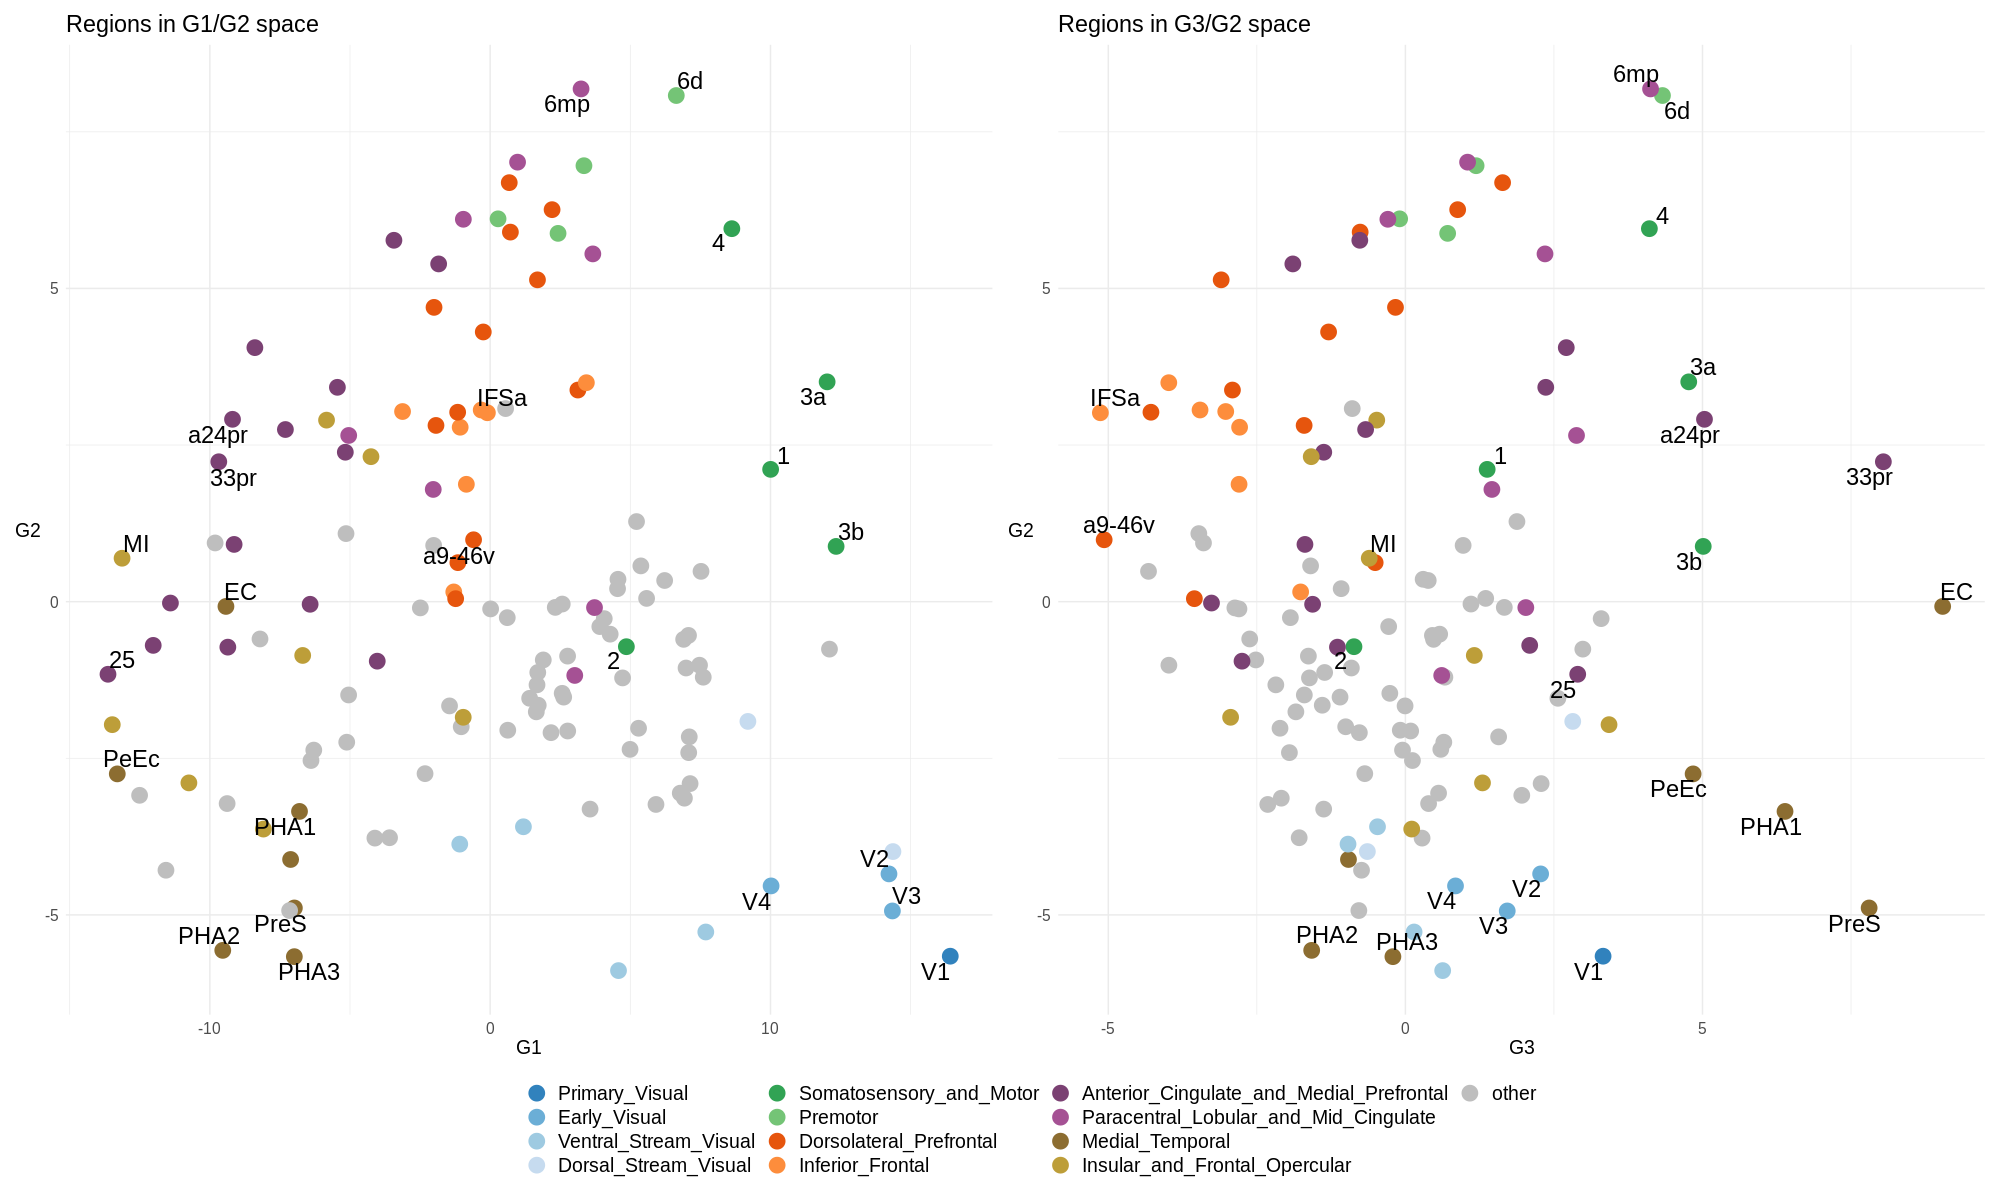

In [736]:
%%R -i df_regions -w 20 -h 12 --units in -r 100
library(pals)
library(ggrepel)

cortex_colors <- c(
    stepped3(20)[c(1,2,3,4,  9,10,  5,6)],
    stepped2(20)[c(17,18,  9,10)]
)

cortex_to_label <- c('Primary_Visual', 'Early_Visual', 'Somatosensory_and_Motor')
region_to_label <- c('25', 'Pol2', 'PeEc', 'MI', '6mp', '6d', 
                     'EC', 'PreS', '33pr', 'PHA1', 'PHA2', 'PHA3', 'IFSa', 'a9-46v', 'a24pr')
data_to_label <- df_regions %>% filter(
    (cortex %in% cortex_to_label) | (label %in% region_to_label)
    )

plot_regions <- function(x='G1', y='G2', legend_position='bottom') {
    df_regions %>%
        # arrange(cortex) %>%
        # mutate(cortex = factor(cortex, ordered=TRUE, levels=c('other', unique(.$cortex[!(.$cortex=='other')])))) %>%
        ggplot(aes(x=get(x), y=get(y))) + 
        geom_point(aes(color=cortex), size=5) +
        # geom_text_repel(aes(label=label), data=df_regions %>% filter(cortex != 'other')) +
        geom_text_repel(aes(label=label), data=data_to_label, size=6) +
        theme_minimal() +
        labs(x=x,y=y) +
        scale_color_manual(values=c(cortex_colors, 'grey')) +
        guides(color=guide_legend(title='', nrow=4)) +
        theme(legend.position=legend_position, 
              axis.title.y=element_text(angle=0, vjust=.5)) +
        ggtitle(paste0('Regions in ',x,'/',y,' space'))
}
(plot_regions() + plot_regions(x='G3') & theme(text=element_text(size=14), legend.text=element_text(size=14))) + plot_layout(guides='collect') + 
    plot_annotation(theme=theme(legend.position='bottom'))

## How does regressing out PCs affect VE?

In [47]:
from sklearn.linear_model import LinearRegression

def regress_out_axes(version, n_axes = 1, norm=False):
    data = version.expression
    axes = version.scores.iloc[:, 0:n_axes]
    lm = LinearRegression().fit(axes, data)
    estimated_data = lm.predict(axes)
    residuals = data - estimated_data

    if norm:
        residuals = residuals.apply(lambda x: (x-np.mean(x))/np.std(x))
    return residuals

expression_dict = {
    'base expression': pca_3d_ds7.expression.apply(lambda x: (x-np.mean(x))/np.std(x)),
    'remove G1': regress_out_axes(pca_3d_ds7, 1),
    'remove G1 & 2': regress_out_axes(pca_3d_ds7, 2),
    'remove G1,2,3': regress_out_axes(pca_3d_ds7, 3),
    'remove G1-5': regress_out_axes(pca_3d_ds7, 5),
    'remove G1-10': regress_out_axes(pca_3d_ds7, 10),
}

residuals = regress_out_axes(pca_3d_ds7, 2)
residuals.iloc[:,:5].corrwith(pca_3d_ds7.scores[1])

A1BG    -1.170754e-16
AAAS     0.000000e+00
AAED1    1.312325e-16
AAK1     4.033962e-17
AARD    -2.444523e-16
dtype: float64

In [833]:
from scipy import sparse

def get_coexp(expression, order=''):

    coexp = expression.T.corr()

    if order=='louvain':
        # Sort by louvain modules
        sp = sparse.csr_matrix(coexp+1)
        modules = Louvain(resolution=1.2).fit_transform(sp)
        ord = modules.argsort()
        coexp = coexp.iloc[ord, ord]
    else:
        # Sort by anatomy
        ord = (fetch_hcp()['info'][:180]
              .sort_values(['Lobe', 'cortex'])
              .set_index('id')
              .loc[expression.index]
              .index
            )
        coexp = coexp.loc[ord, ord]
    
    coexp = coexp.set_axis(range(expression.shape[0])).set_axis(range(expression.shape[0]), axis=1)
    return coexp


coexp_dict = {
    'anatomical\nordering': {name:get_coexp(expression) for name, expression in expression_dict.items()},
    'louvain\nordering': {name:get_coexp(expression, order='louvain') for name, expression in expression_dict.items()},
}

In [834]:
df_coexp = (pd.concat({name:pd.concat(coexp) for name, coexp in coexp_dict.items()})
    .melt(ignore_index=False)
    .reset_index()
    .set_axis(['ordering', 'version', 'x', 'y', 'r'], axis=1)
)
df_coexp

ordering          version    x    y         r
0       anatomical\nordering  base expression    0    0  1.000000
1       anatomical\nordering  base expression    1    0  0.958267
2       anatomical\nordering  base expression    2    0  0.945921
3       anatomical\nordering  base expression    3    0  0.878285
4       anatomical\nordering  base expression    4    0  0.503125
...                      ...              ...  ...  ...       ...
225223     louvain\nordering     remove G1-10  132  136 -0.037275
225224     louvain\nordering     remove G1-10  133  136  0.280820
225225     louvain\nordering     remove G1-10  134  136  0.168296
225226     louvain\nordering     remove G1-10  135  136 -0.159338
225227     louvain\nordering     remove G1-10  136  136  1.000000

[225228 rows x 5 columns]

In [866]:
df_coexp_mean = (df_coexp
                 .assign(r = lambda x: np.where(x['x']==x['y'], 0, x['r']))
                 .groupby(['version', 'ordering', 'x']).agg({'r':'mean'}).reset_index()
                 .assign(version = lambda x: pd.Categorical(x['version'], ordered=True, 
                                            categories=x.groupby('version').mean().sort_values('r').index))
                 .sort_values('version', ascending=False))

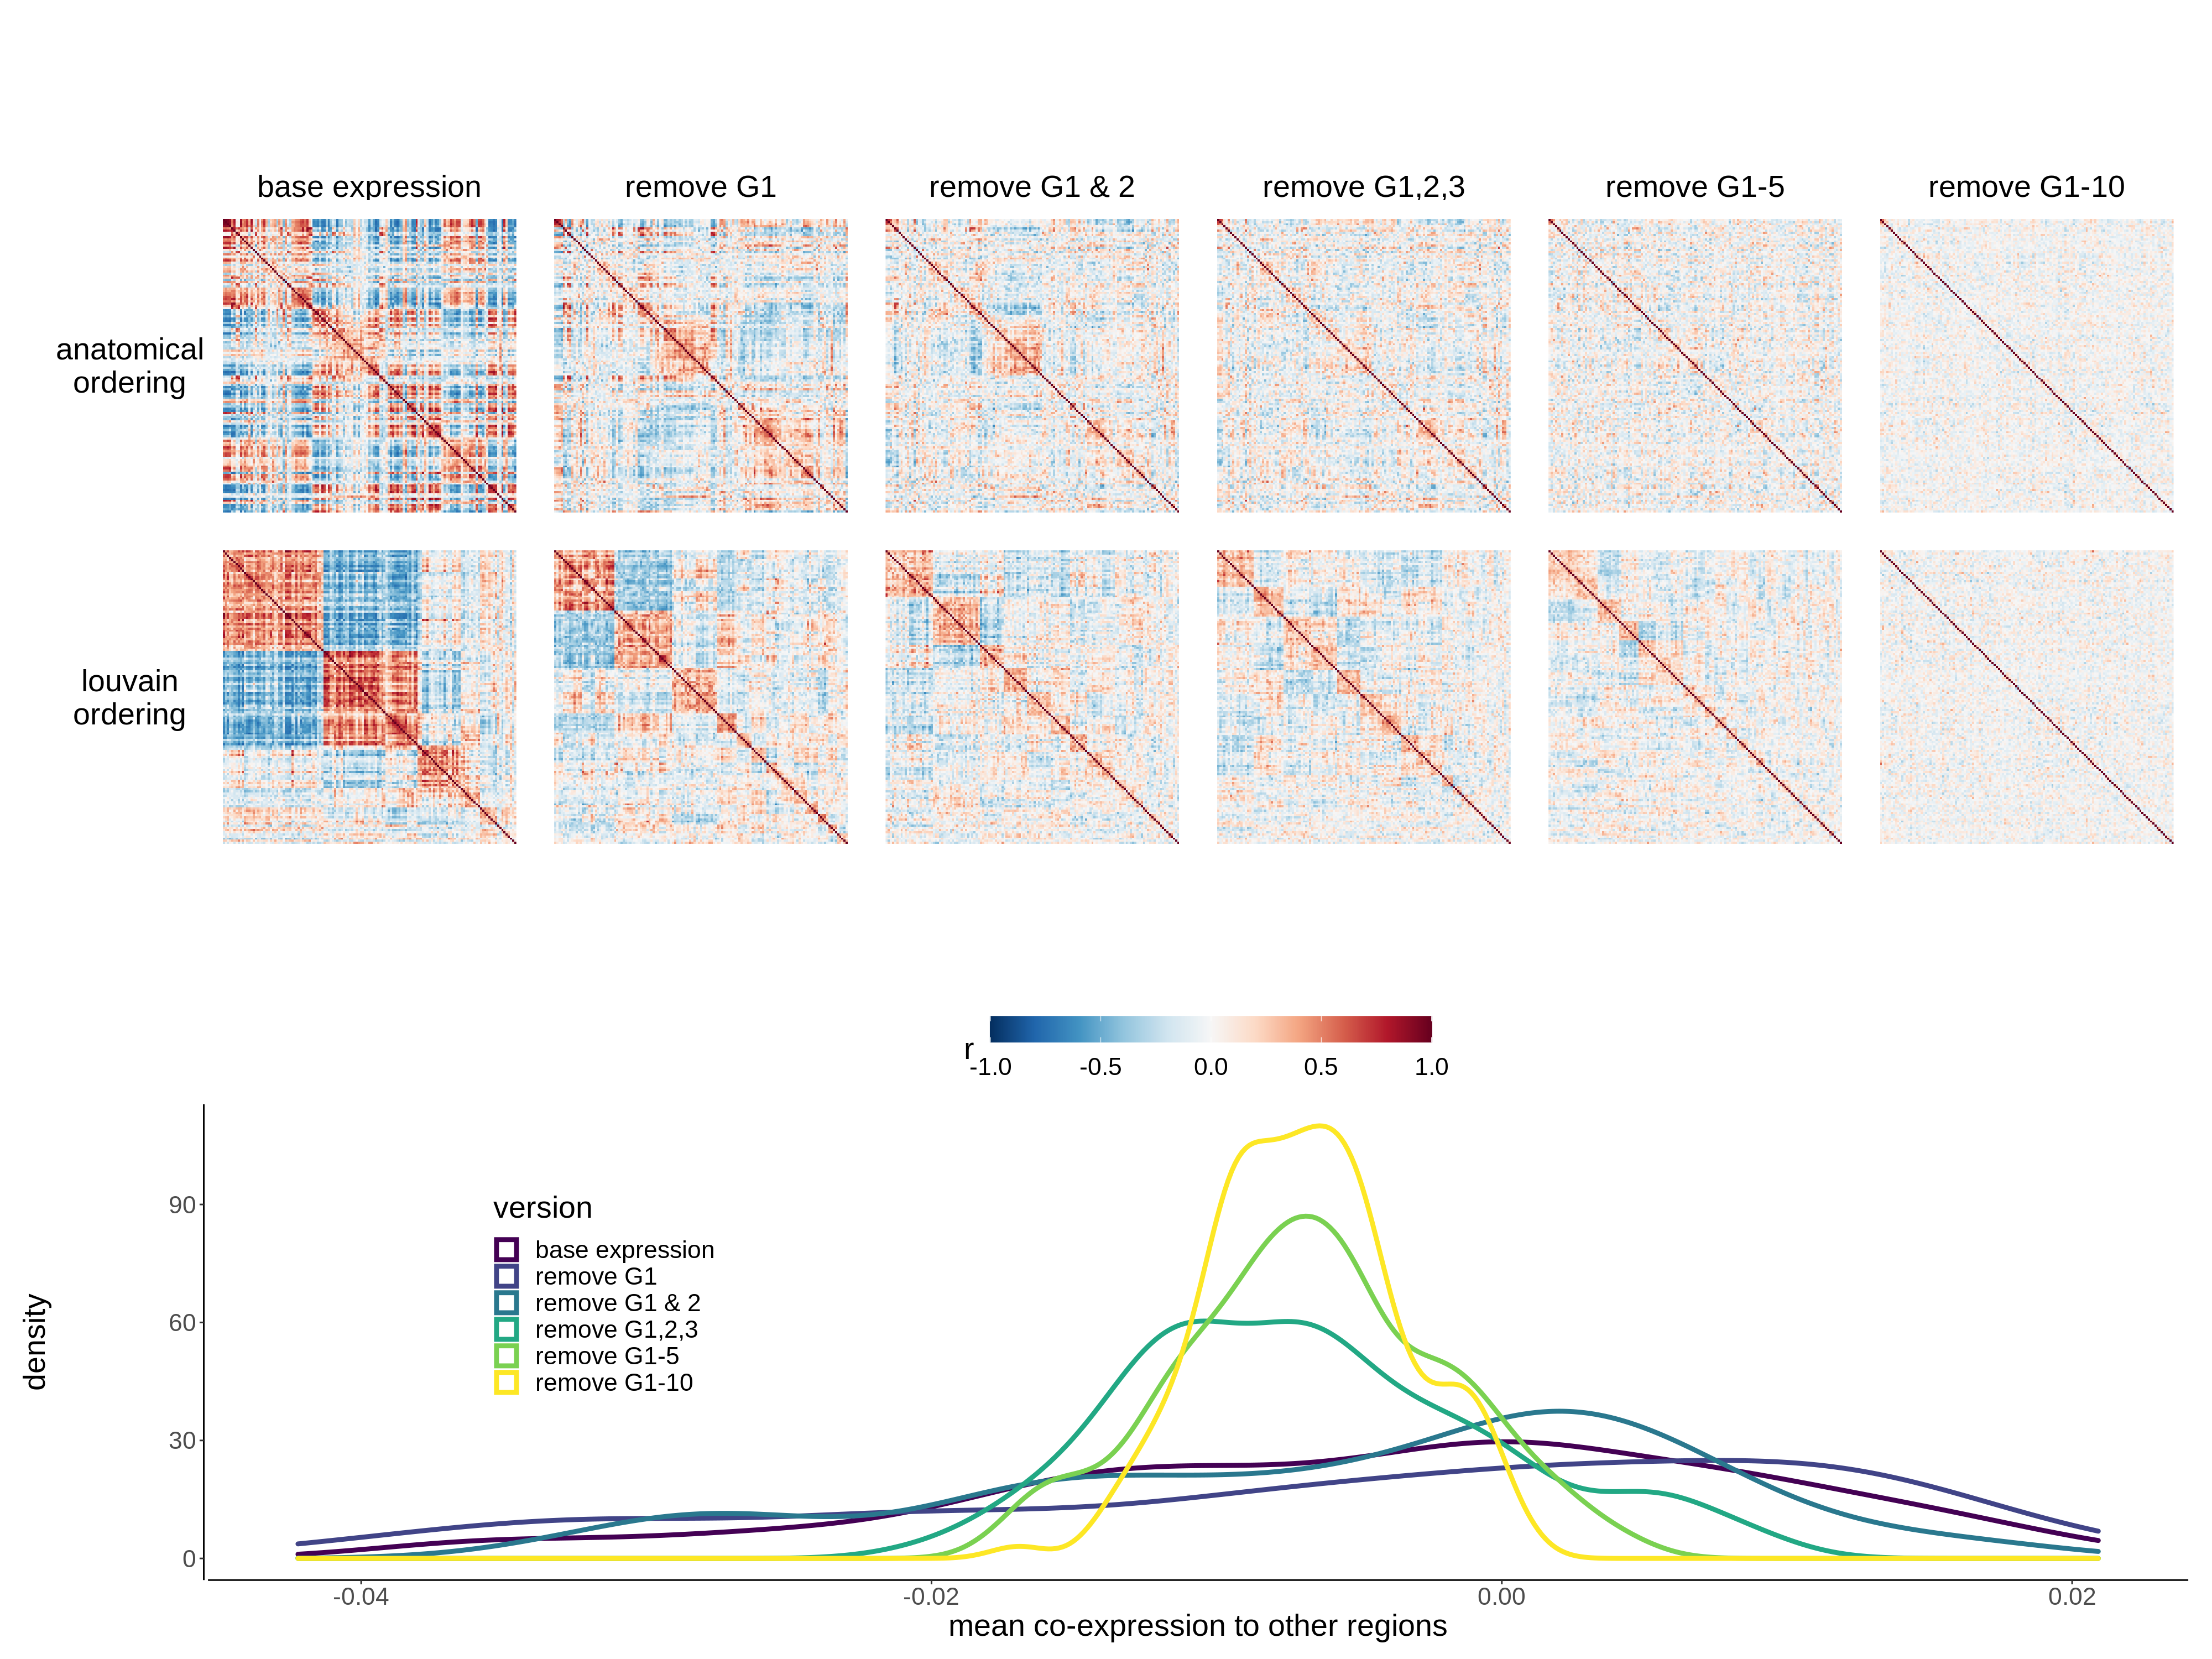

In [867]:
%%R -i df_coexp -i df_coexp_mean -w 20 -h 15 --units in -r 200

g1 = df_coexp %>%
    mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>%
    ggplot(aes(x, rev(y), fill=r)) +
    facet_grid(ordering ~ version, switch='y') +
    geom_raster() +
    scale_fill_gradientn(colors=rev(brewer.rdbu(200)), limits=c(-1,1)) +
    theme_void() +
    guides(fill=guide_colorbar(barwidth=20)) +
    theme(aspect.ratio=1, 
          plot.margin=margin(10,10,10,10),
          strip.text.y.left=element_text(angle=0, vjust=.5),
          strip.text = element_text(size=20),
          strip.placement='outside',
          text = element_text(size=20),
          legend.position='bottom'
          )

g2 = df_coexp_mean %>%
    mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>%
    ggplot(aes(r, color=version)) +
    geom_density(size=1.5) + 
    xlab('mean co-expression to other regions') +
    theme_classic() +
    theme(text=element_text(size=20), legend.position = c(.2,.6))

(g1 / g2) + plot_layout(heights=c(2,1))

In [154]:
pca_3d_ds7.var[1:] / res.var().sum()

print("Eigenvalues (variances):", pca_3d_ds7.var)
print("Total variance (PC1 residuals):", residuals.var().sum())
print("% Variance Explained:", pca_3d_ds7.var / residuals.var().sum())

Eigenvalues (variances): [44.13181035 10.5987166   6.62760673  4.30203585  2.81404117]
Total variance (PC1 residuals): 51.43320852219938
% Variance Explained: [0.85804117 0.20606758 0.12885851 0.08364316 0.05471253]


In [312]:
pca_res = gradientVersion(approach='pca', n_components=5).fit(residuals)

New gradients version: method=pca, kernel=None, sparsity=0, data=(data given)


In [300]:
pca_res.var / pca_res.expression.var().sum()

pca_res = gradientVersion(approach='pca', n_components=5).fit(residuals)
print("Eigenvalues (variances):", pca_res.var)
print("Total variance (PC1 residuals):", residuals.var().sum())
print("% Variance Explained:", pca_res.var / residuals.var().sum())

Eigenvalues (variances): [10.5987166   6.62760673  4.30203585  2.81404117  2.64421354]
Total variance (PC1 residuals): 51.433208522199386
% Variance Explained: [0.20606758 0.12885851 0.08364316 0.05471253 0.05141063]


In [311]:
correlate(pca_res.scores, pca_3d_ds7.scores).round(5)

0    1    2    3    4
0 -0.0  1.0 -0.0  0.0  0.0
1  0.0 -0.0 -1.0 -0.0  0.0
2 -0.0 -0.0 -0.0  1.0 -0.0
3 -0.0 -0.0  0.0  0.0  1.0
4 -0.0 -0.0  0.0  0.0 -0.0

## Gene correlations after regressing out

In [760]:
no_G1 = regress_out_axes(pca_3d_ds7, 1)
pca_3d_ds7_noG1 = gradientVersion(approach='pca').fit(no_G1 - no_G1.min().min())

New gradients version: method=pca, kernel=None, sparsity=0, data=(data given)


In [778]:
no_G12 = regress_out_axes(pca_3d_ds7, 2)
pca_3d_ds7_noG12 = gradientVersion(approach='pca').fit(no_G12 - no_G12.min().min())

New gradients version: method=pca, kernel=None, sparsity=0, data=(data given)


In [782]:
version = pca_3d_ds7
correlate(version.expression, version.scores.iloc[:,:3])

0         1         2
A1BG   -0.805791 -0.138600 -0.028184
AAAS    0.608539  0.161728 -0.086439
AAED1  -0.728849  0.041575  0.178471
AAK1    0.692467  0.037084 -0.074158
AARD    0.676577 -0.112135 -0.051584
...          ...       ...       ...
ZSWIM9 -0.542126  0.030850  0.190885
ZWINT  -0.648236 -0.210807 -0.019823
ZYX     0.897696  0.145694 -0.215620
ZZEF1   0.672454 -0.313515  0.289722
ZZZ3   -0.578460 -0.113698  0.016441

[4784 rows x 3 columns]

In [783]:
def get_gene_axis_corrs(version, start_label=1):
    return (correlate(version.expression, version.scores.iloc[:,:3])
            .set_axis([f'G{i+start_label}' for i in range(3)], axis=1))
corrs_dict = {
    'all': get_gene_axis_corrs(pca_3d_ds7, 1),
    'no G1': get_gene_axis_corrs(pca_3d_ds7_noG1, 2),
    'no G1,2': get_gene_axis_corrs(pca_3d_ds7_noG12, 3)
}

In [787]:
df_corrs = (pd.concat(corrs_dict)
            .melt(ignore_index=False, var_name='G', value_name='r')
            .reset_index(0).rename({'level_0':'version'}, axis=1)
)
df_corrs

version   G         r
A1BG        all  G1 -0.805791
AAAS        all  G1  0.608539
AAED1       all  G1 -0.728849
AAK1        all  G1  0.692467
AARD        all  G1  0.676577
...         ...  ..       ...
ZSWIM9  no G1,2  G5  0.056657
ZWINT   no G1,2  G5 -0.450403
ZYX     no G1,2  G5 -0.346390
ZZEF1   no G1,2  G5 -0.076376
ZZZ3    no G1,2  G5 -0.050074

[71760 rows x 3 columns]

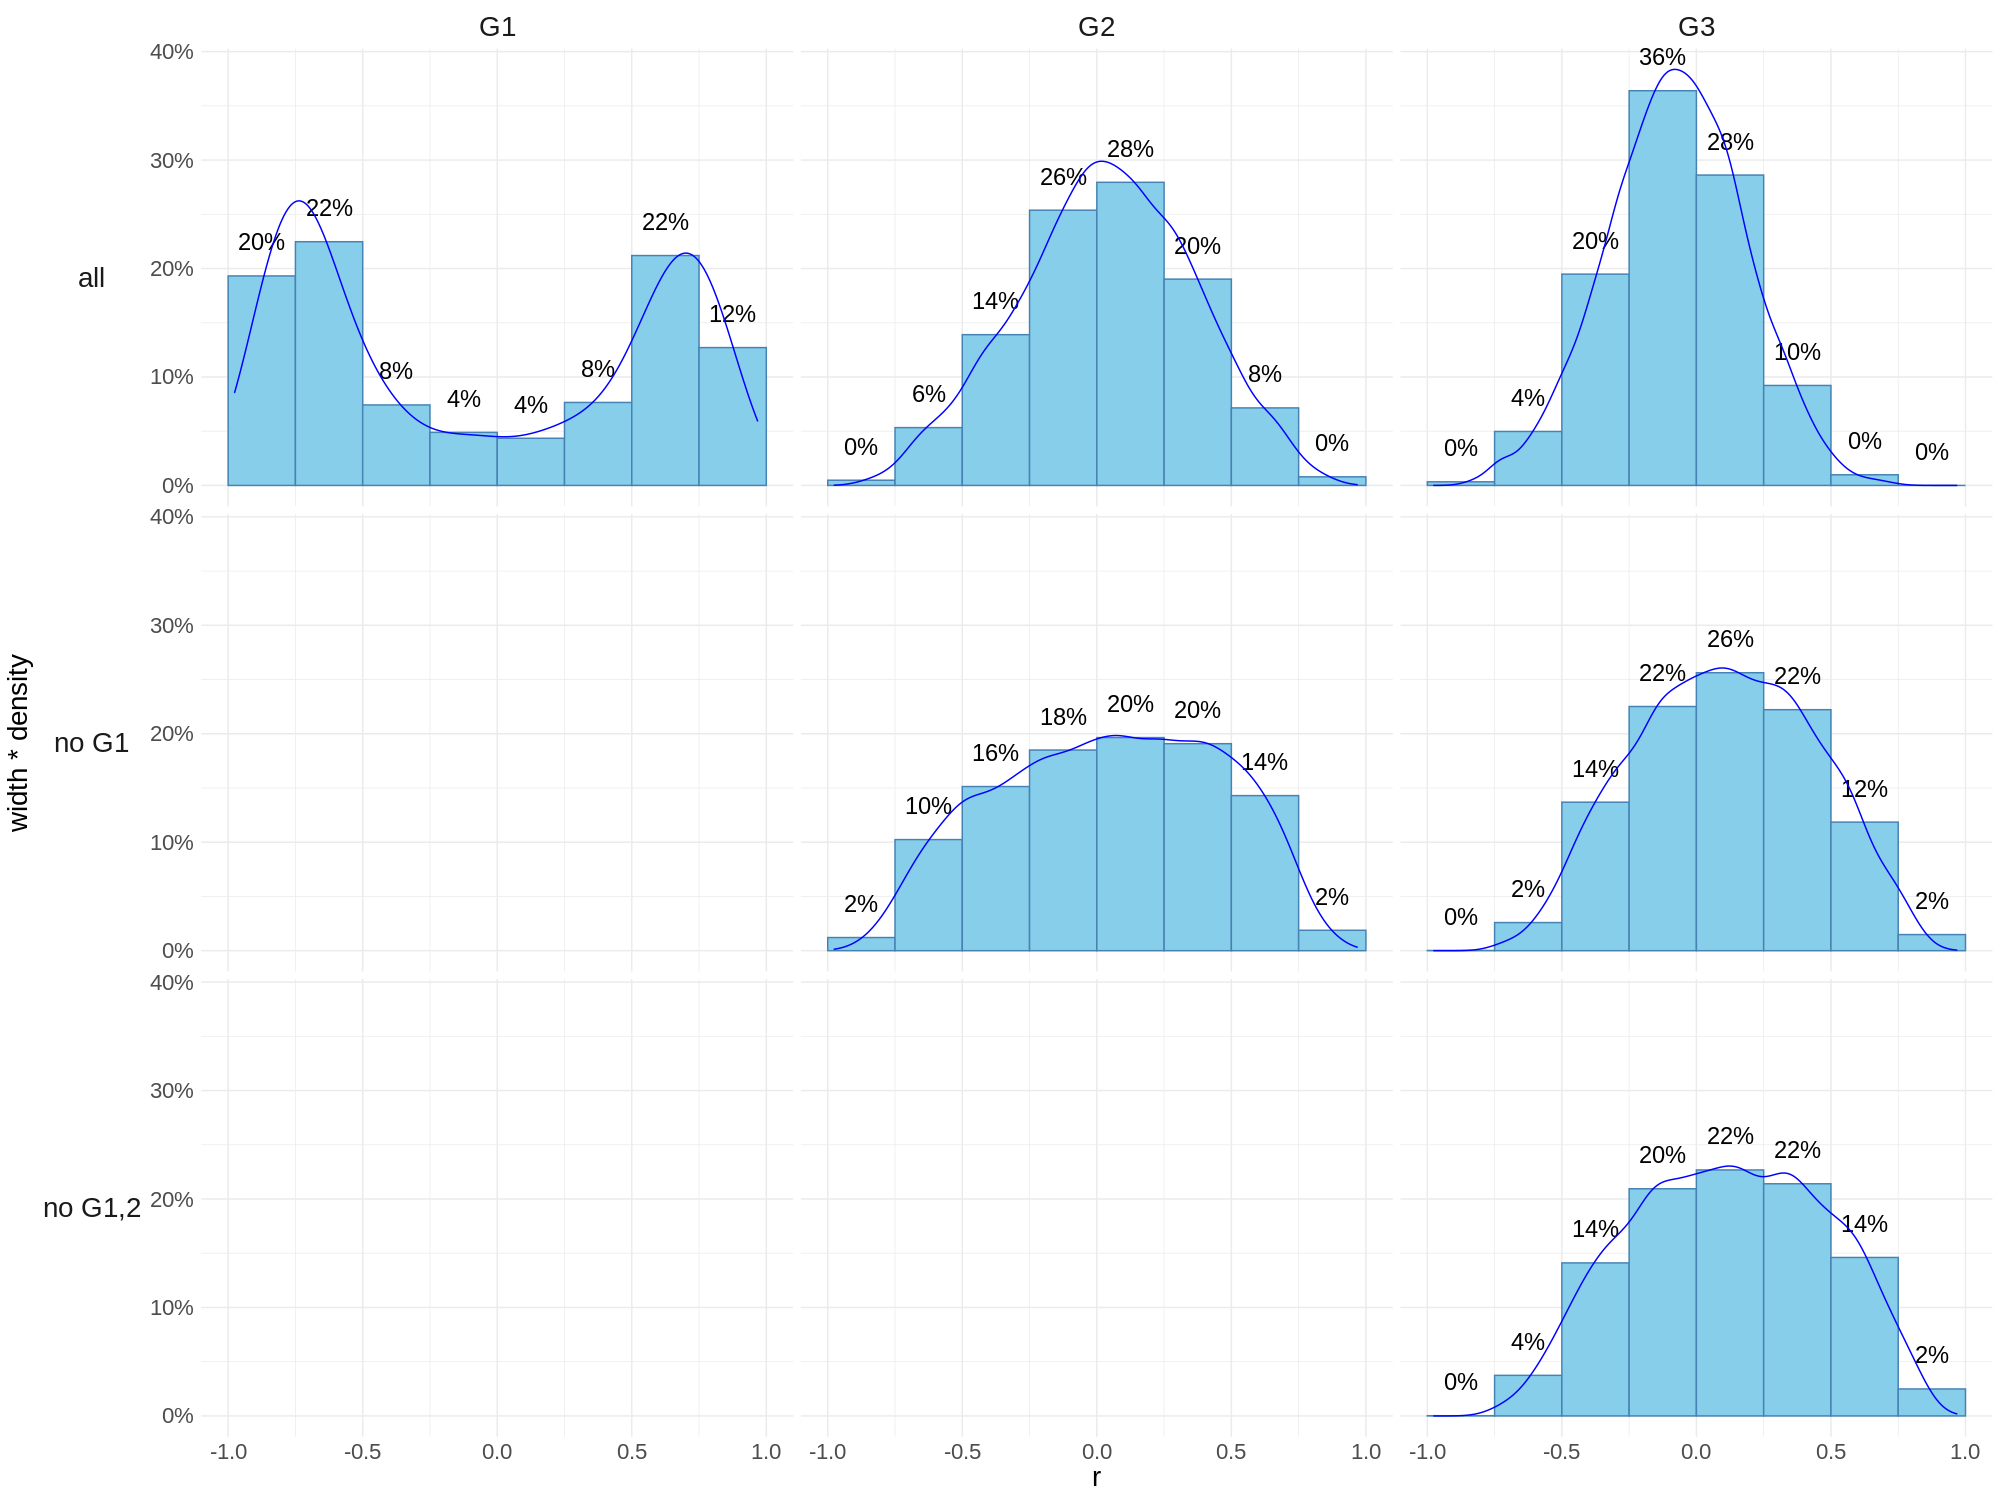

In [827]:
%%R -i df_corrs -w 20 -h 15 --units in -r 100
df_corrs %>% 
filter(!(G %in% c('G4', 'G5'))) %>%
ggplot(aes(x=r)) + 
geom_histogram(aes(y=stat(width*density)), breaks=seq(-1,1,.25), fill='skyblue', color='steelblue') +
stat_bin(breaks=seq(-1,1,.25), geom="text", aes(y=stat(width*density), label=percent(stat(width*density),2)), vjust=-1.5, size=6) +
geom_density(aes(y=..density../4), color='blue') +
scale_y_continuous(labels=percent_format()) +
facet_grid(version~G, switch='y') +
theme_minimal() + 
theme(text=element_text(size=20),
      strip.placement='outside',
      strip.text.y.left=element_text(size=20, angle=0, vjust=.5),
      strip.text.x=element_text(size=20)
)

## How does normalization affect VE?

In [30]:
# _, stability_noSampleNorm, _ = get_expression_abagen(
#     atlas=fetch_hcp(), 
#     save_name='hcp_3donors_ds7_noSampleNorm',
#     donors_threshold=3,
#     gene_stability_threshold=0.7,
#     # gene_norm=None,
#     sample_norm=None,
#     return_stability=True
# )

In [34]:
pca_3d_ds7_noNorm = gradientVersion(approach='pca').fit('hcp_3donors_ds7_noNorm')
pca_3d_ds7_noGeneNorm = gradientVersion(approach='pca').fit('hcp_3donors_ds7_noGeneNorm')
pca_3d_ds7_noSampleNorm = gradientVersion(approach='pca').fit('hcp_3donors_ds7_noSampleNorm')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_3donors_ds7_noNorm
New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_3donors_ds7_noGeneNorm
New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_3donors_ds7_noSampleNorm


In [344]:
print("No normalisation:\n", pca_3d_ds7_noNorm.var / pca_3d_ds7_noNorm.expression.var().sum())
print("Normalise both genes & samples:\n", pca_3d_ds7.var / pca_3d_ds7.expression.var().sum())
print("Normalise samples only:\n", pca_3d_ds7_noGeneNorm.var / pca_3d_ds7_noGeneNorm.expression.var().sum())
print("Normalise genes only:\n", pca_3d_ds7_noSampleNorm.var / pca_3d_ds7_noSampleNorm.expression.var().sum())


No normalisation:
 [0.41130615 0.09732519 0.07853392 0.05537819 0.04356923]
Normalise both genes & samples:
 [0.46179879 0.11090582 0.06935181 0.04501685 0.02944635]
Normalise samples only:
 [0.43125696 0.1032194  0.07775563 0.04760523 0.03671397]
Normalise genes only:
 [0.43514015 0.10599403 0.0819533  0.05927442 0.03670899]


array([0.41130615, 0.09732519, 0.07853392, 0.05537819, 0.04356923])

In [37]:
pca_3d_ds7_noNorm.corr_scores(pca_3d_ds7)

0         1         2         3         4
0  0.993145  0.000916 -0.039599  0.008965 -0.006146
1  0.000173  0.975958 -0.036975  0.102488  0.040040
2  0.048534 -0.005442  0.887049  0.119634 -0.065787
3 -0.001445 -0.067684 -0.227754 -0.292610 -0.320159
4  0.005722  0.145541  0.244584 -0.709294  0.183331

### How does normalisation affect expression distribution?

In [ ]:
df_exp = (pd.concat({
    '1) no normalisation': pca_3d_ds7_noNorm.expression,
    '2) normalise both genes & samples': pca_3d_ds7.expression,
    '3) normalise samples only': pca_3d_ds7_noGeneNorm.expression,
    '4) normalise genes only': pca_3d_ds7_noSampleNorm.expression
}).melt(ignore_index=False)
  .reset_index().set_axis(['version', 'region', 'gene', 'exp'], axis=1)
)

df_exp = (pd.concat({
  'gene expression (mean of regions)': df_exp.groupby(['version', 'gene']).mean().reset_index(),
  'region expression (mean of genes)': df_exp.groupby(['version', 'region']).mean().reset_index()
}).reset_index().rename({'level_0':'genes_or_regions'}, axis=1)
)

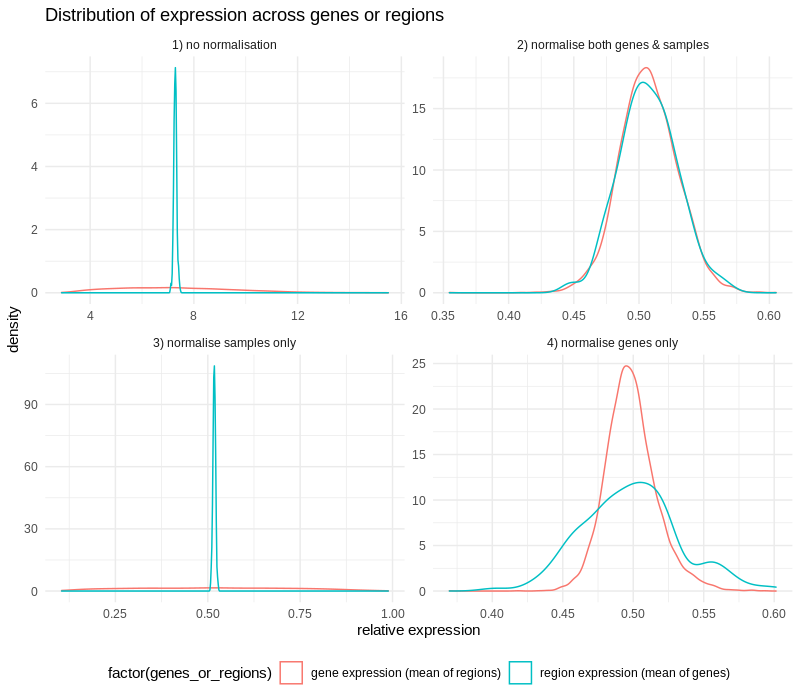

In [342]:
%%R -i df_exp -w 8 -h 7 --units in -r 100
df_exp %>%
    mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>%
    ggplot(aes(x=exp, color=factor(genes_or_regions))) + 
    facet_wrap(~version, scales='free') +
    geom_density() +
    theme_minimal() + 
    theme(legend.position='bottom') +
    scale_x_continuous('relative expression') +
    ggtitle('Distribution of expression across genes or regions')

### Distributions of expressions by normalisation

In [88]:
version = pca_3d_ds7
def get_expression_top100genes(version, group='label', agg='mean'):
    exp_top100 = {}
    for i in range(3):
        ix_top100 = np.argsort(version.weights[i]).loc[lambda x: x<100].index.values
        ix_bot100 = np.argsort(version.weights[i]).loc[lambda x: (max(x)-x)<100].index.values
        ix_both = np.concatenate([ix_top100, ix_bot100])
        exp_top100[i] = (version.expression.loc[:, ix_both].melt(ignore_index=False, var_name='gene')
                            .groupby(group).agg(agg))
    out = (pd.concat(exp_top100)
            .reset_index().set_axis(['PC', 'group', 'exp'], axis=1)
            .replace({'PC':{0:'PC1', 1:'PC2', 2:'PC3'}})
    )
    return out

df_top100_exp = pd.concat({
    '1) no normalisation': get_expression_top100genes(pca_3d_ds7_noNorm),
    '2) normalise both genes & samples': get_expression_top100genes(pca_3d_ds7),
    '3) normalise samples only': get_expression_top100genes(pca_3d_ds7_noGeneNorm),
    '4) normalise genes only': get_expression_top100genes(pca_3d_ds7_noSampleNorm)
}).reset_index(0).rename({'level_0':'version'}, axis=1)
df_top100_exp

version   PC  group       exp
0        1) no normalisation  PC1      1  6.737015
1        1) no normalisation  PC1      4  6.813332
2        1) no normalisation  PC1      5  6.775826
3        1) no normalisation  PC1      6  6.846979
4        1) no normalisation  PC1      8  6.879654
..                       ...  ...    ...       ...
406  4) normalise genes only  PC3    175  0.509920
407  4) normalise genes only  PC3    176  0.494604
408  4) normalise genes only  PC3    177  0.488340
409  4) normalise genes only  PC3    178  0.499815
410  4) normalise genes only  PC3    179  0.560525

[1644 rows x 4 columns]

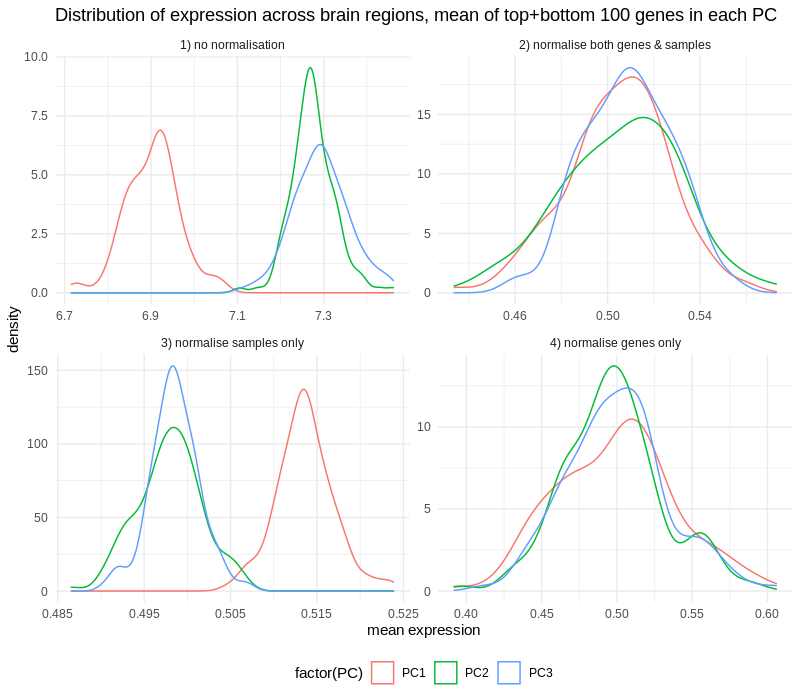

In [96]:
%%R -i df_top100_exp -w 8 -h 7 --units in -r 100
df_top100_exp %>%
    mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>%
    ggplot(aes(x=exp, color=factor(PC))) + 
    facet_wrap(~version, scales='free') +
    geom_density() +
    theme_minimal() + 
    theme(legend.position='bottom') +
    scale_x_continuous('mean expression') +
    ggtitle('Distribution of expression across brain regions, mean of top+bottom 100 genes in each PC')

In [ ]:
df_top100_exp_var = pd.concat({
    '1) no normalisation': get_expression_top100genes(pca_3d_ds7_noNorm, agg='var'),
    '2) normalise both genes & samples': get_expression_top100genes(pca_3d_ds7, agg='var'),
    '3) normalise samples only': get_expression_top100genes(pca_3d_ds7_noGeneNorm, agg='var'),
    '4) normalise genes only': get_expression_top100genes(pca_3d_ds7_noSampleNorm, agg='var')
}).reset_index(0).rename({'level_0':'version'}, axis=1)


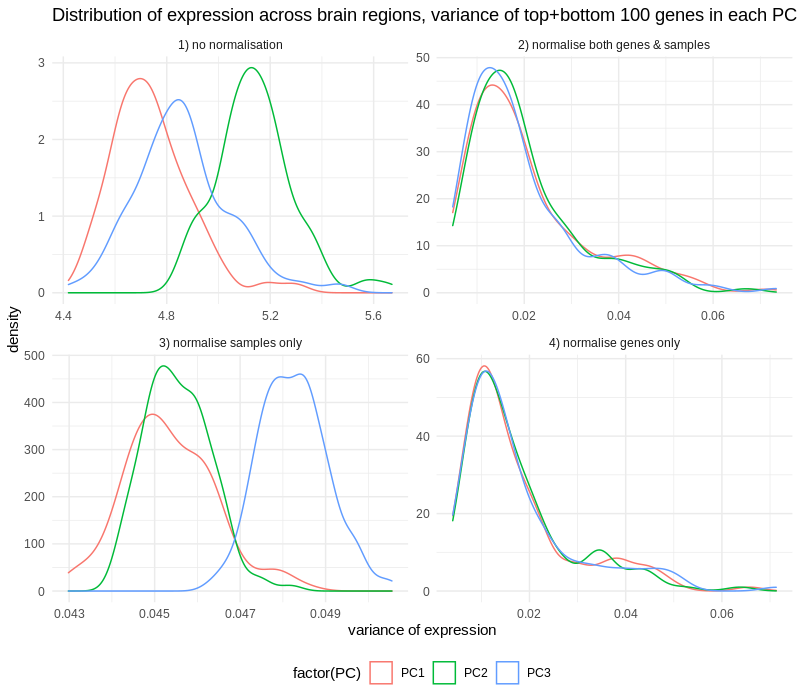

In [102]:
%%R -i df_top100_exp_var -w 8 -h 7 --units in -r 100
df_top100_exp_var %>%
    mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>%
    ggplot(aes(x=exp, color=factor(PC))) + 
    facet_wrap(~version, scales='free') +
    geom_density() +
    theme_minimal() + 
    theme(legend.position='bottom') +
    scale_x_continuous('variance of expression') +
    ggtitle('Distribution of expression across brain regions, variance of top+bottom 100 genes in each PC')

In [100]:
df_top100_exp_by_genes = pd.concat({
    '1) no normalisation': get_expression_top100genes(pca_3d_ds7_noNorm, group='gene'),
    '2) normalise both genes & samples': get_expression_top100genes(pca_3d_ds7, group='gene'),
    '3) normalise samples only': get_expression_top100genes(pca_3d_ds7_noGeneNorm, group='gene'),
    '4) normalise genes only': get_expression_top100genes(pca_3d_ds7_noSampleNorm, group='gene')
}).reset_index(0).rename({'level_0':'version'}, axis=1)
df_top100_exp_by_genes

version   PC    group        exp
0        1) no normalisation  PC1   ADAM22  10.166955
1        1) no normalisation  PC1  ADIPOR1   7.979651
2        1) no normalisation  PC1      ADK   7.616858
3        1) no normalisation  PC1    ALDOC  11.256404
4        1) no normalisation  PC1    ARL4A   7.457650
..                       ...  ...      ...        ...
595  4) normalise genes only  PC3      VIP   0.507998
596  4) normalise genes only  PC3   ZNF136   0.486175
597  4) normalise genes only  PC3   ZNF350   0.508202
598  4) normalise genes only  PC3   ZNF641   0.488040
599  4) normalise genes only  PC3    ZNRF1   0.496768

[2400 rows x 4 columns]

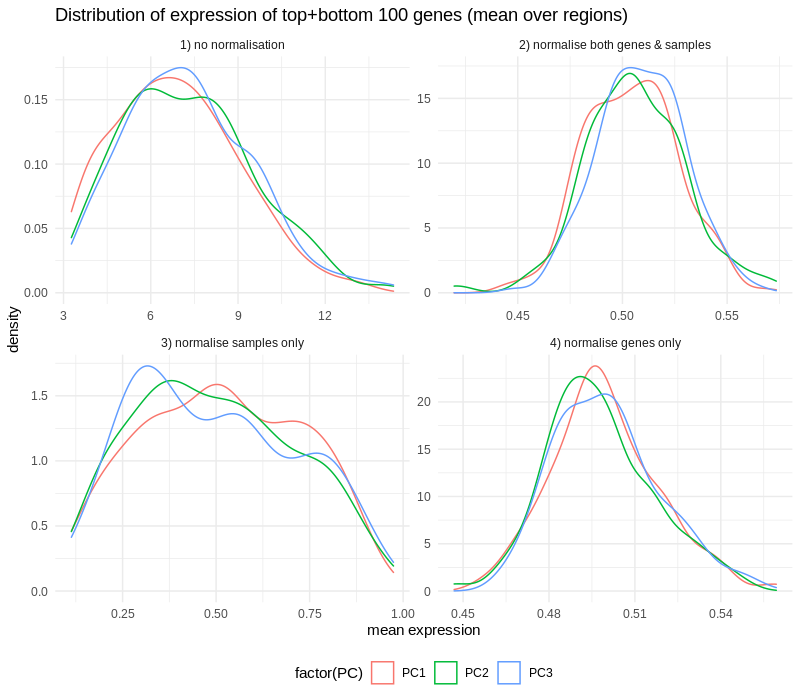

In [103]:
%%R -i df_top100_exp_by_genes -w 8 -h 7 --units in -r 100
df_top100_exp_by_genes %>%
    mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>%
    ggplot(aes(x=exp, color=factor(PC))) + 
    facet_wrap(~version, scales='free') +
    geom_density() +
    theme_minimal() + 
    theme(legend.position='bottom') +
    scale_x_continuous('mean expression') +
    ggtitle('Distribution of expression of top+bottom 100 genes (mean over regions)')

In [105]:
df_top100_exp_var_by_genes = pd.concat({
    '1) no normalisation': get_expression_top100genes(pca_3d_ds7_noNorm, group='gene', agg='var'),
    '2) normalise both genes & samples': get_expression_top100genes(pca_3d_ds7, group='gene', agg='var'),
    '3) normalise samples only': get_expression_top100genes(pca_3d_ds7_noGeneNorm, group='gene', agg='var'),
    '4) normalise genes only': get_expression_top100genes(pca_3d_ds7_noSampleNorm, group='gene', agg='var')
}).reset_index(0).rename({'level_0':'version'}, axis=1)

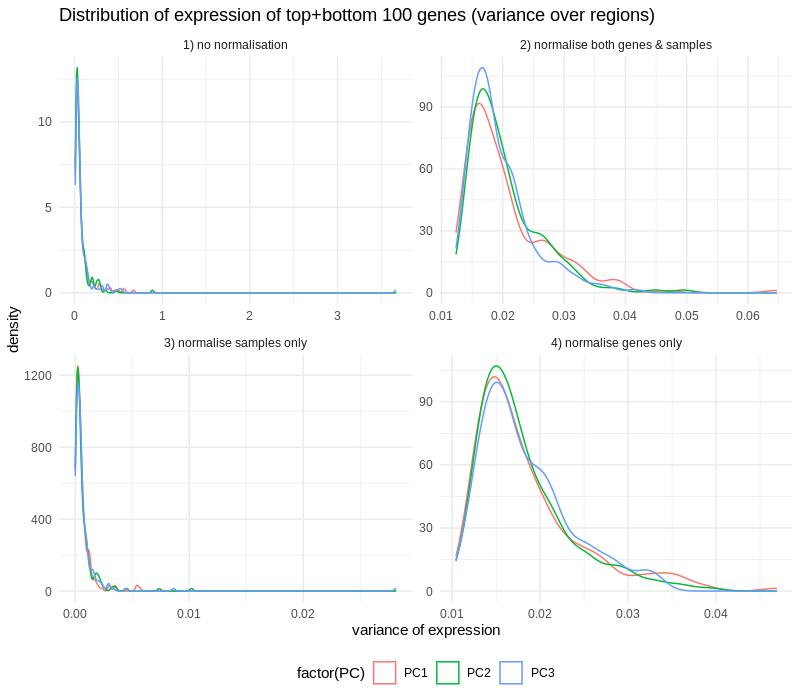

In [107]:
%%R -i df_top100_exp_var_by_genes -w 8 -h 7 --units in -r 100
df_top100_exp_var_by_genes %>%
    mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>%
    ggplot(aes(x=exp, color=factor(PC))) + 
    facet_wrap(~version, scales='free') +
    geom_density() +
    theme_minimal() + 
    theme(legend.position='bottom') +
    scale_x_continuous('variance of expression') +
    ggtitle('Distribution of expression of top+bottom 100 genes (variance over regions)')

In [373]:
version = pca_3d_ds7
def get_expression_topregions(version, group='gene', agg='mean'):
    exp_top = {}
    for i in range(3):
        ix_top = np.argsort(version.scores[i]).loc[lambda x: x<5].index.values
        ix_bot = np.argsort(version.scores[i]).loc[lambda x: (max(x)-x)<5].index.values
        ix_both = np.concatenate([ix_top, ix_bot])
        exp_top[i] = (version.expression.loc[ix_both, :].melt(ignore_index=False, var_name='gene')
                            .groupby(group).agg(agg))
    out = (pd.concat(exp_top)
            .reset_index().set_axis(['PC', 'group', 'exp'], axis=1)
            .replace({'PC':{0:'PC1', 1:'PC2', 2:'PC3'}})
    )
    return out

df_topregions_exp = pd.concat({
    '1) no normalisation': get_expression_topregions(pca_3d_ds7_noNorm),
    '2) normalise both genes & samples': get_expression_topregions(pca_3d_ds7),
    '3) normalise samples only': get_expression_topregions(pca_3d_ds7_noGeneNorm),
    '4) normalise genes only': get_expression_topregions(pca_3d_ds7_noSampleNorm)
}).reset_index(0).rename({'level_0':'version'}, axis=1)
df_topregions_exp

version   PC    group       exp
0          1) no normalisation  PC1     A1BG  8.274497
1          1) no normalisation  PC1     AAAS  6.853650
2          1) no normalisation  PC1     AAK1  8.254290
3          1) no normalisation  PC1     AARD  5.547160
4          1) no normalisation  PC1    ABCA5  8.441883
...                        ...  ...      ...       ...
14347  4) normalise genes only  PC3  ZSCAN5A  0.504245
14348  4) normalise genes only  PC3   ZSCAN9  0.474088
14349  4) normalise genes only  PC3   ZSWIM4  0.445263
14350  4) normalise genes only  PC3    ZWINT  0.425773
14351  4) normalise genes only  PC3      ZYX  0.424843

[57408 rows x 4 columns]

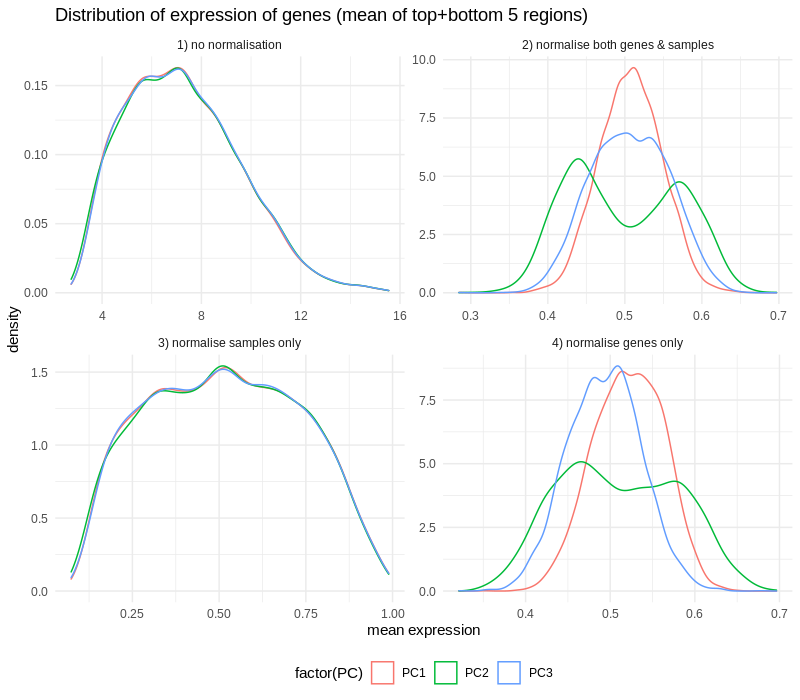

In [375]:
%%R -i df_topregions_exp -w 8 -h 7 --units in -r 100
df_topregions_exp %>%
    mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>%
    ggplot(aes(x=exp, color=factor(PC))) + 
    facet_wrap(~version, scales='free') +
    geom_density() +
    theme_minimal() + 
    theme(legend.position='bottom') +
    scale_x_continuous('mean expression') +
    ggtitle('Distribution of expression of genes (mean of top+bottom 5 regions)')

## What if we remove visual cortex?

In [364]:
visual_cortex = ['Primary_Visual', 'Early_Visual', 'Dorsal_Stream_Visual', 'Ventral_Stream_Visual']# , 'Somatosensory_and_Motor']
visual_regions = fetch_hcp()['info'].loc[lambda x: np.isin(x['cortex'], visual_cortex), 'id']

hcp_3d_ds7_no_visual = pca_3d_ds7_noNorm.expression.loc[lambda x: ~np.isin(x.index, visual_regions), :]

In [365]:
pca_3d_ds7_no_visual = gradientVersion(approach='pca').fit(hcp_3d_ds7_no_visual)

New gradients version: method=pca, kernel=None, sparsity=0, data=(data given)


In [366]:
pca_3d_ds7_no_visual.corr_scores(pca_3d_ds7).round(3)

0      1      2      3      4
0  0.988  0.245 -0.143 -0.097 -0.052
1 -0.011  0.836  0.464  0.196  0.075
2  0.100 -0.418  0.744 -0.157 -0.162
3  0.035 -0.052  0.303  0.161  0.251
4 -0.018  0.185  0.159 -0.660  0.214

In [367]:
print("% Variance Explained (no norm, no visual cortex):", pca_3d_ds7_no_visual.var / pca_3d_ds7_no_visual.expression.var().sum())

% Variance Explained (no norm, no visual cortex): [0.38353813 0.09557784 0.08310355 0.05817894 0.04712175]


## How does VE relate to noise?

In [ ]:
all_donors = list(fetch_hcp()['image'].keys())

for n_donors in range(1,6):
    donors = all_donors[0:n_donors+1]
    _ = get_expression_abagen(
        atlas=fetch_hcp(),
        save_name=f'hcp_Ndonors{n_donors+1}',
        donors=donors,
        donors_threshold=1,
        gene_stability_threshold=0,
        ibf_threshold=0
    )
    print(f"Saved all-genes expression with {n_donors+1} donors")

Saved all-genes expression with 2 donors
Saved all-genes expression with 3 donors
Saved all-genes expression with 4 donors
Saved all-genes expression with 5 donors
Saved all-genes expression with 6 donors


First confirm that projecting preserves correct VE when n_genes = n_PCs

In [129]:
pca_ds7_Ndonors6 = gradientVersion('pca').fit('hcp_ds7_Ndonors6', scale=False)
pca_Ndonors2 = gradientVersion('pca').fit('hcp_Ndonors2', scale=False)

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_ds7_Ndonors6
New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_Ndonors2


In [131]:
np.linalg.norm(pca_ds7_Ndonors6.weights, axis=0)

array([1., 1., 1., 1., 1.])

In [130]:
pca_ds7_Ndonors6_5genes = gradientVersion('pca', marker_genes=[]).fit(pca_ds7_Ndonors6.expression.iloc[:,:5])

data_Ndonors2_5genes_match = pca_Ndonors2.expression.loc[:,pca_ds7_Ndonors6_5genes.expression.columns]
pca_Ndonors2_5genes_match = gradientVersion('pca', marker_genes=[]).fit(data_Ndonors2_5genes_match)

New gradients version: method=pca, kernel=None, sparsity=0, data=(data given)
New gradients version: method=pca, kernel=None, sparsity=0, data=(data given)


In [132]:
pca_Ndonors2_5genes_match.expression.var().sum()

0.09507218440376668

In [133]:
(pca_Ndonors2_5genes_match.expression @ pca_ds7_Ndonors6_5genes.weights).var().sum()
# (pca_Ndonors2_5genes_match.expression @ pca_ds7_Ndonors6_5genes.weights).var() / pca_Ndonors2_5genes_match.expression.var().sum()

0.09482040286665012

In [143]:
data_list = [pd.read_csv(f"../data/abagen-data/expression/hcp_Ndonors{i+1}.csv", index_col=0) for i in range(1,6)]

In [150]:
common_genes = set.intersection(*[set(v.columns) for v in data_list])
common_genes = set.intersection(common_genes, pca_ds7_Ndonors6.expression.columns)

In [235]:
base = gradientVersion('pca').fit(pca_ds7_Ndonors6.expression.loc[:, list(common_genes)])

var_explained_Ndonors_dict = {}
for i in range(1,6):
    # Read all-genes expression data from fewer donors
    data = pd.read_csv(f"../data/abagen-data/expression/hcp_Ndonors{i+1}.csv", index_col=0)
    
    # Filter for matched genes
    data_matched = data.loc[:, base.expression.columns]
    # Project into target space
    scores_projected = data_matched @ base.weights
    # scores_projected = gradientVersion('pca').fit(data_matched).scores
    
    # Get total variance
    total_var = data_matched.var().sum()
    # Get var explained pct
    var_explained_Ndonors_dict[i+1] = scores_projected.var() / total_var

New gradients version: method=pca, kernel=None, sparsity=0, data=(data given)


In [236]:
df_Ndonors_var = pd.concat(var_explained_Ndonors_dict).to_frame().reset_index().set_axis(['Ndonors', 'PC', 'VE'], axis=1) \
                    .replace({'PC':{i:i+1 for i in range(6)}})

In [237]:
df = df_Ndonors_var.loc[lambda x: x['PC']==2, :]

def extrapolate(df, n_max=30):
    X = np.array(range(2,7)).reshape(-1,1)
    y = df['VE']
    X_new = np.array(range(2, n_max+1)).reshape(-1,1)
    extrapolation = LinearRegression().fit(X, y).predict(X_new)
    return df.drop('PC', axis=1).set_index('Ndonors').reindex(range(2, n_max+1)).assign(VE_pred = extrapolation)

df_Ndonors_var_pred = (
    df_Ndonors_var.groupby('PC').apply(extrapolate)
    .reset_index().loc[lambda x: ~(x['PC']==1 & x['VE'].isnull())]
)

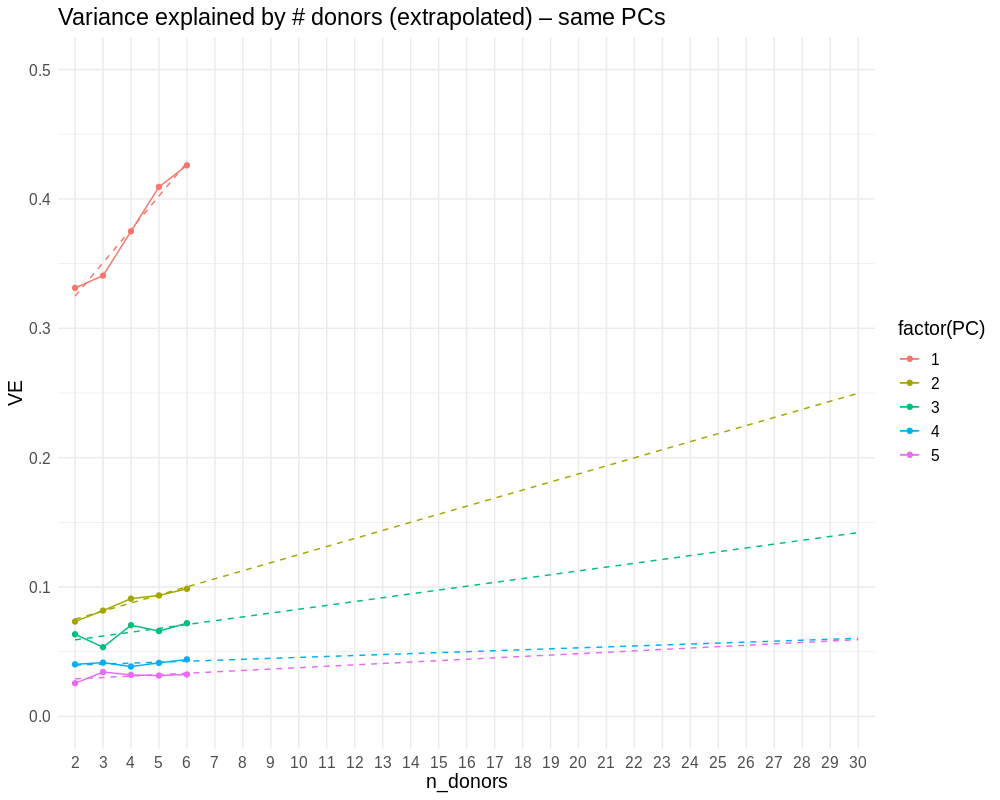

In [239]:
%%R -i df_Ndonors_var_pred -w 10 -h 8 --units in -r 100
df_Ndonors_var_pred %>%
    mutate(n_donors = factor(Ndonors)) %>%
    ggplot(aes(x=n_donors, y=VE, color=factor(PC))) + 
    geom_line(aes(group=PC)) +
    geom_point(aes(group=PC)) +
    geom_line(aes(group=PC, y=VE_pred), linetype=2) +
    ylim(0,.5) +
    theme_minimal() +
    theme(text=element_text(size=14)) +
    ggtitle("Variance explained by # donors (extrapolated) – same PCs")

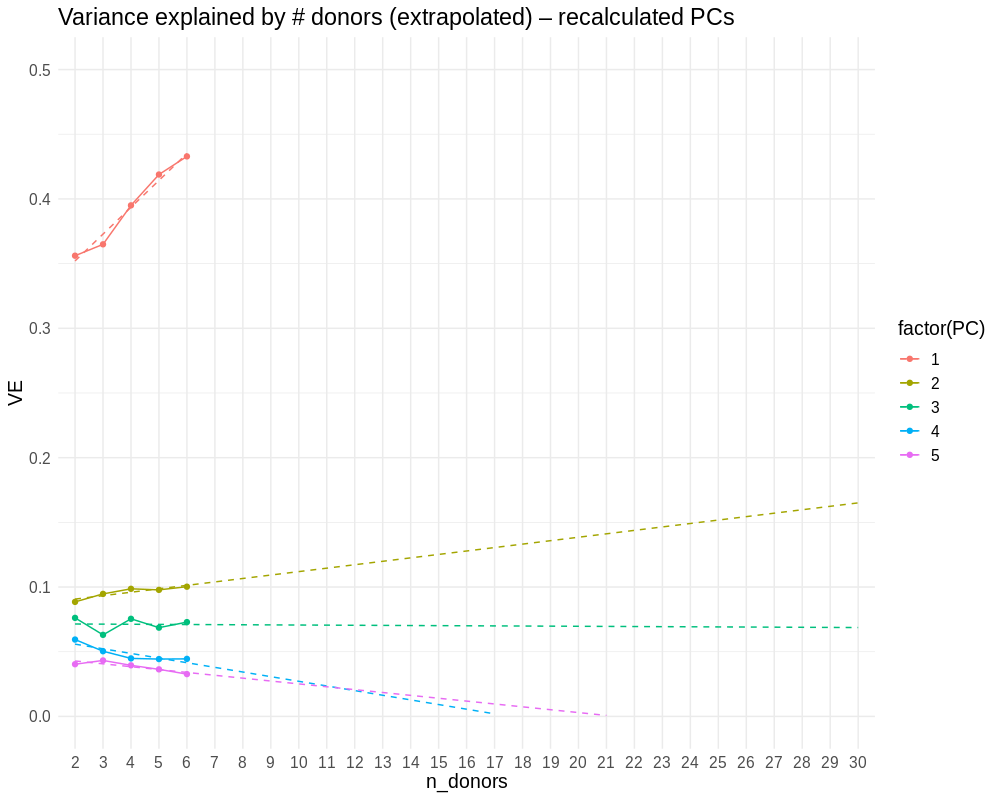

In [234]:
%%R -i df_Ndonors_var_pred -w 10 -h 8 --units in -r 100
df_Ndonors_var_pred %>%
    mutate(n_donors = factor(Ndonors)) %>%
    ggplot(aes(x=n_donors, y=VE, color=factor(PC))) + 
    geom_line(aes(group=PC)) +
    geom_point(aes(group=PC)) +
    geom_line(aes(group=PC, y=VE_pred), linetype=2) +
    ylim(0,.5) +
    theme_minimal() +
    theme(text=element_text(size=14)) +
    ggtitle("Variance explained by # donors (extrapolated) – recalculated PCs")

## Variance explained of DME...

In [263]:
hcp_3d_ds7 = pd.read_csv("../data/abagen-data/expression/hcp_3donors_ds7.csv", index_col=0)
hcp_3d_ds7_5genes = hcp_3d_ds7.iloc[:, :5]

In [339]:
# pca_3d_ds7 = gradientVersion('pca', marker_genes=[]).fit(hcp_3d_ds7)
# dme_3d_ds7 = gradientVersion('dm', marker_genes=[]).fit(hcp_3d_ds7)
dme_3d_ds5 = gradientVersion('dm').fit('hcp_3donors_ds5')

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [403]:
np.set_printoptions(precision=4)

print("--- PCA (5 gene data) ---")
print(f"Total expression variance: {pca_3d_ds7_5genes.expression.var().sum():.4f}")
print("Eigenvalues:", pca_3d_ds7_5genes.eigenvalues, f" (sum = {pca_3d_ds7_5genes.eigenvalues.sum():.4f})")
print("Variance of scores:", pca_3d_ds7_5genes.scores.var().values, f" (sum = {pca_3d_ds7_5genes.scores.var().sum():.4f})")
pct = pca_3d_ds7_5genes.eigenvalues / pca_3d_ds7_5genes.expression.var().sum()
print("% variance explained:", pct, f" (sum = {pct.sum():.4f})")

print("\n--- DME (5 gene data) ---")
print(f"Total expression variance: {dme_3d_ds7_5genes.expression.var().sum():.4f}")
print("Eigenvalues:", dme_3d_ds7_5genes.eigenvalues, f" (sum = {dme_3d_ds7_5genes.eigenvalues.sum():.4f})")
print("Variance of scores:", dme_3d_ds7_5genes.scores.var().values, f" (sum = {dme_3d_ds7_5genes.scores.var().sum():.4f})")

# print(f"\nTotal affinity matrix variance (incorrect!): {dme_3d_ds7_5genes.affinity.var().sum():.4f}")
# pct = dme_3d_ds7_5genes.scores.var().values / dme_3d_ds7_5genes.affinity.var().sum()
# print("% variance explained (scores/affinity):" , pct, f" (sum = {pct.sum():.4f})")

print(f"\nTotal affinity matrix variance (correct): {dme_3d_ds7_5genes.affinity.var(0).sum():.4f}")
pct = dme_3d_ds7_5genes.eigenvalues / dme_3d_ds7_5genes.affinity.var(0).sum()
print("% variance explained (eigenvalues/affinity):" , pct, f" (sum = {pct.sum():.4f})")


--- PCA (5 gene data) ---
Total expression variance: 0.0793
Eigenvalues: [0.0498 0.0114 0.0069 0.0063 0.0048]  (sum = 0.0793)
Variance of scores: [0.0498 0.0114 0.0069 0.0063 0.0048]  (sum = 0.0793)
% variance explained: [0.6287 0.1439 0.0876 0.0792 0.0606]  (sum = 1.0000)

--- DME (5 gene data) ---
Total expression variance: 0.0793
Eigenvalues: [0.0366 0.0111 0.0073 0.0062 0.0053]  (sum = 0.0665)
Variance of scores: [1.3485e-03 1.2350e-04 5.4094e-05 3.8937e-05 2.8174e-05]  (sum = 0.0016)

Total affinity matrix variance (correct): 0.2132
% variance explained (eigenvalues/affinity): [0.1716 0.0519 0.0344 0.0292 0.0248]  (sum = 0.3119)


In [406]:
np.set_printoptions(precision=4)

print("--- PCA (4784 gene data) ---")
print(f"Total expression variance: {pca_3d_ds7.expression.var().sum():.4f}")
print("Eigenvalues:", pca_3d_ds7.eigenvalues, f" (sum = {pca_3d_ds7.eigenvalues.sum():.4f})")
print("Variance of scores:", pca_3d_ds7.scores.var().values, f" (sum = {pca_3d_ds7.scores.var().sum():.4f})")
pct = pca_3d_ds7.eigenvalues / pca_3d_ds7.expression.var().sum()
print("% variance explained:", pct, f" (sum = {pct.sum():.4f})")

print("\n--- DME (7973 gene data) ---")
print(f"Total expression variance: {dme_3d_ds5.expression.var().sum():.4f}")
print("Eigenvalues:", dme_3d_ds5.eigenvalues, f" (sum = {dme_3d_ds5.eigenvalues.sum():.4f})")
print("Variance of scores:", dme_3d_ds5.scores.var().values, f" (sum = {dme_3d_ds5.scores.var().sum():.4f})")

print(f"\nTotal affinity matrix variance (incorrect!): {dme_3d_ds5.affinity.var().sum():.4f}")
pct = dme_3d_ds5.scores.var().values / dme_3d_ds5.affinity.var().sum()
print("% variance explained (scores/affinity):" , pct, f" (sum = {pct.sum():.4f})")

print(f"\nTotal affinity matrix variance (correct): {dme_3d_ds5.affinity.var(0).sum():.4f}")
pct = dme_3d_ds5.eigenvalues / dme_3d_ds5.affinity.var(0).sum()
print("% variance explained (eigenvalues/affinity):" , pct, f" (sum = {pct.sum():.4f})")


--- PCA (4784 gene data) ---
Total expression variance: 95.5650
Eigenvalues: [44.1318 10.5987  6.6276  4.302   2.814 ]  (sum = 68.4742)
Variance of scores: [44.1318 10.5987  6.6276  4.302   2.814 ]  (sum = 68.4742)
% variance explained: [0.4618 0.1109 0.0694 0.045  0.0294]  (sum = 0.7165)

--- DME (7973 gene data) ---
Total expression variance: 137.0299
Eigenvalues: [0.0229 0.0082 0.0063 0.004  0.0035]  (sum = 0.0449)
Variance of scores: [5.2955e-04 6.6923e-05 3.9506e-05 1.6477e-05 1.2658e-05]  (sum = 0.0007)

Total affinity matrix variance (incorrect!): 0.0010
% variance explained (scores/affinity): [0.5431 0.0686 0.0405 0.0169 0.013 ]  (sum = 0.6821)

Total affinity matrix variance (correct): 0.1036
% variance explained (eigenvalues/affinity): [0.2213 0.0787 0.0604 0.039  0.0342]  (sum = 0.4336)


In [363]:
np.set_printoptions(precision=4)
dme_test = gradientVersion('dm', n_components=10).fit('hcp_3donors_ds5')

print("\n--- DME (7973 gene data, 137 samples, 10 components) ---")
# print(f"Total expression variance: {dme_test.expression.var().sum():.4f}")
print(f"Eigenvalues sum (n=10): {dme_test.eigenvalues.sum():.4f})")
pct = dme_test.eigenvalues[:5] / dme_test.eigenvalues.sum()
print("% variance explained (eigenvalues/sum(eigenvalues)):" , pct, f" (sum = {pct.sum():.4f})")
print("Eigenvalues:", dme_test.eigenvalues, f" (sum = {dme_test.eigenvalues.sum():.4f})")
# print("Variance of scores:", dme_test.scores.var().values, f" (sum = {dme_test.scores.var().sum():.4f})")
# print(f"Total affinity matrix variance: {dme_test.affinity.var().sum():.4f}")
# pct = dme_test.scores.var().values / dme_test.affinity.var().sum()
# print("% variance explained (scores/affinity):" , pct, f" (sum = {pct.sum():.4f})")
# pct = dme_test.eigenvalues / dme_test.expression.var().sum()
# print("% variance explained (eigenvalues/expression):" , pct, f" (sum = {pct.sum():.4f})")


New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5

--- DME (7973 gene data, 137 samples, 10 components) ---
Eigenvalues sum (n=10): 0.0565)
% variance explained (eigenvalues/sum(eigenvalues)): [0.4061 0.1444 0.1109 0.0716 0.0628]  (sum = 0.7958)
Eigenvalues: [0.0229 0.0082 0.0063 0.004  0.0035 0.0029 0.0025 0.0025 0.002  0.0017]  (sum = 0.0565)


In [274]:
pca_3d_ds7_5genes.scores.var() / pca_3d_ds7_5genes.expression.var().sum()

0    0.628660
1    0.143944
2    0.087638
3    0.079199
4    0.060559
dtype: float64

In [368]:
dme_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [373]:
dm_hcp_3d_ds5.scores.var() / dm_hcp_3d_ds5.affinity.var().sum()
# dme_hcp_3d_ds5.eigenvalues / dm_hcp_3d_ds5.affinity.var().sum()

0   0.543
1   0.069
2   0.041
3   0.017
4   0.013
dtype: float64

## Moran's I

In [529]:
dme_ds8 = gradientVersion().fit('hcp_ds8')

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_ds8


In [493]:
# dme_3d_ds5.scores.apply(lambda x: (x-np.mean(x))/np.std(x)).apply(get_moran_I)
dme_3d_ds5.scores.apply(get_moran_I)

0   0.485
1   0.583
2   0.206
3   0.313
4   0.140
dtype: float64

In [492]:
dme_3d_ds5.expression.iloc[:,:10].apply(lambda x: (x-np.mean(x))/np.std(x)).apply(get_moran_I)
# get_moran_I(dme_3d_ds5.expression.iloc[:,10])
# dme_3d_ds5.expression.iloc[:,10]

A1BG       0.479
A1BG-AS1   0.234
AAAS       0.144
AAED1      0.221
AAGAB      0.249
AAK1       0.232
AARD       0.345
AARS       0.294
AASDH      0.394
AATF       0.240
dtype: float64

In [444]:
gene_smoothness = dme_3d_ds5.expression.apply(lambda x: (x-np.mean(x))/np.std(x)).apply(get_moran_I)

In [445]:
gene_smoothness.to_frame('moran').to_csv("../outputs/gene_smoothness_hcp_3d_ds5.csv")

In [534]:

dme_3d_ds5.weights.apply(lambda x:
    gene_smoothness[abs(x).sort_values(ascending=False)[:1000].index].reset_index(drop=True)
).mean()

0   0.388
1   0.326
2   0.206
3   0.208
4   0.167
dtype: float64

In [418]:
version = dme_3d_ds5
df = correlate(version.expression, version.scores.iloc[:,:3])

In [446]:
df_plot = (df.set_axis(['G1','G2','G3'],axis=1).join(gene_smoothness.rename('moran'))
           .melt(id_vars='moran', var_name='G', value_name='r'))

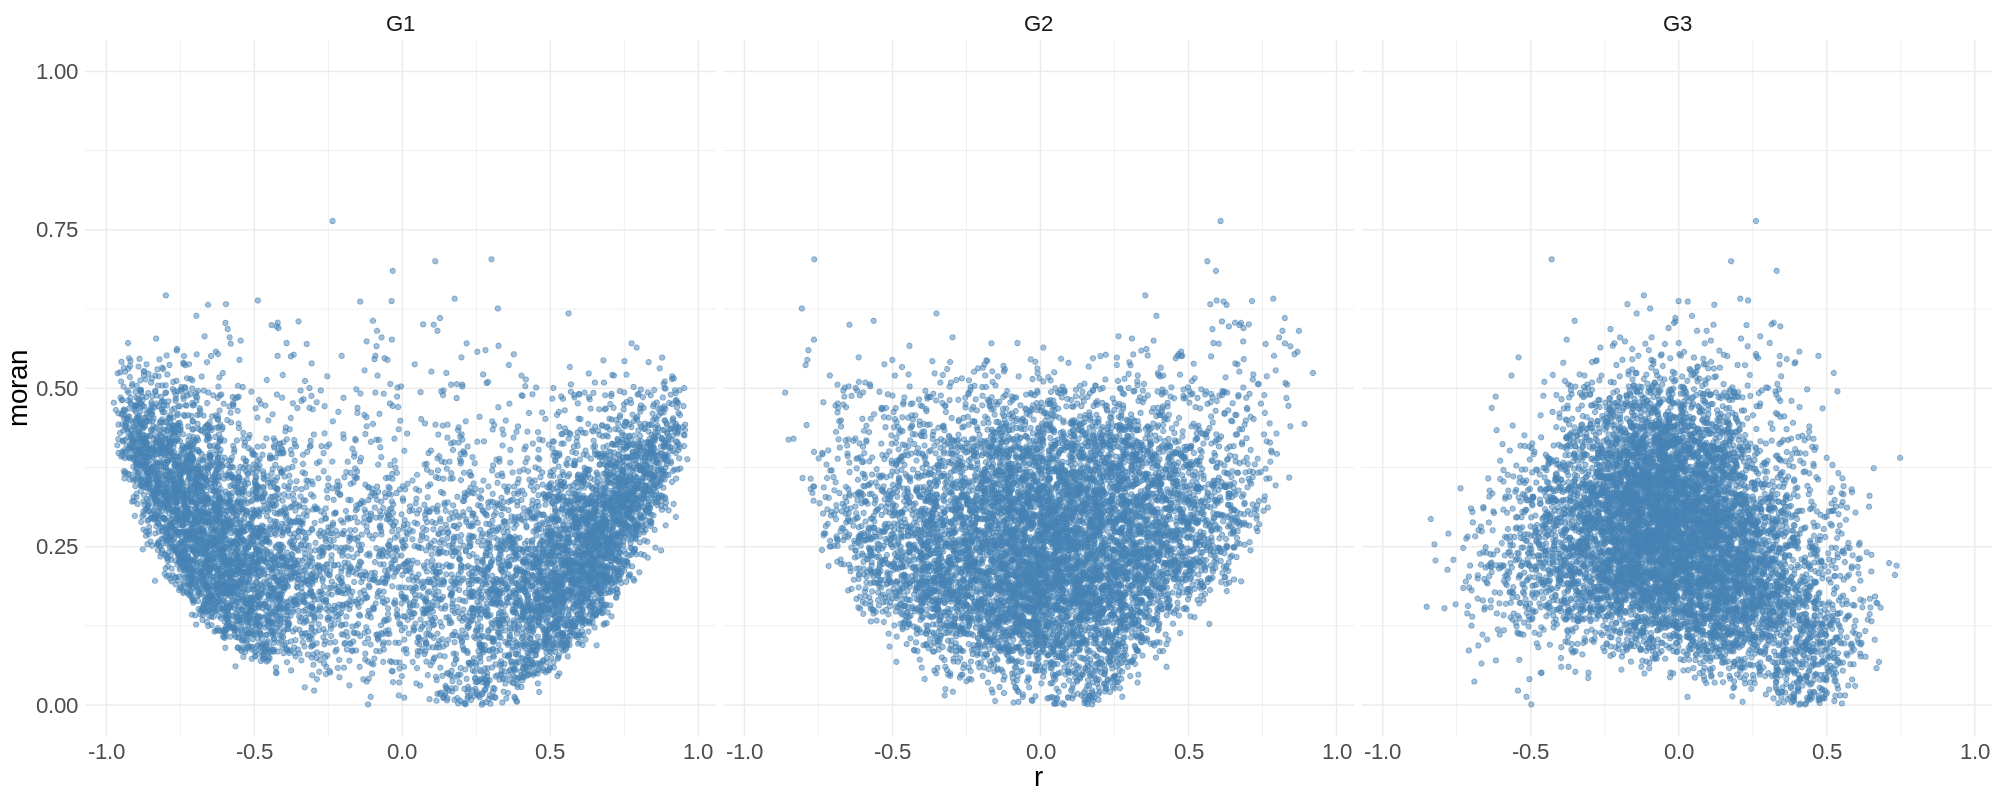

In [452]:
%%R -i df_plot -w 20 -h 8 --units in -r 100
df_plot %>% 
ggplot(aes(r, moran)) +
facet_wrap(~G) +
geom_point(color='steelblue', alpha=.5) + 
ylim(c(0,1)) +
theme_minimal() + 
theme(text=element_text(size=20))

In [459]:
# no_G1 = regress_out_axes(dme_3d_ds5, 1)
# dme_3d_ds5_noG1 = gradientVersion(approach='dm').fit(no_G1 - no_G1.min().min())

no_G12 = regress_out_axes(dme_3d_ds5, 2)
dme_3d_ds5_noG12 = gradientVersion(approach='dm').fit(no_G12 - no_G12.min().min())

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=(data given)


In [460]:
version = dme_3d_ds5_noG12
df = correlate(version.expression, version.scores.iloc[:,:3])

In [461]:
df_plot = (df.set_axis(['G3','G4','G5'],axis=1).join(gene_smoothness.rename('moran'))
           .melt(id_vars='moran', var_name='G', value_name='r'))

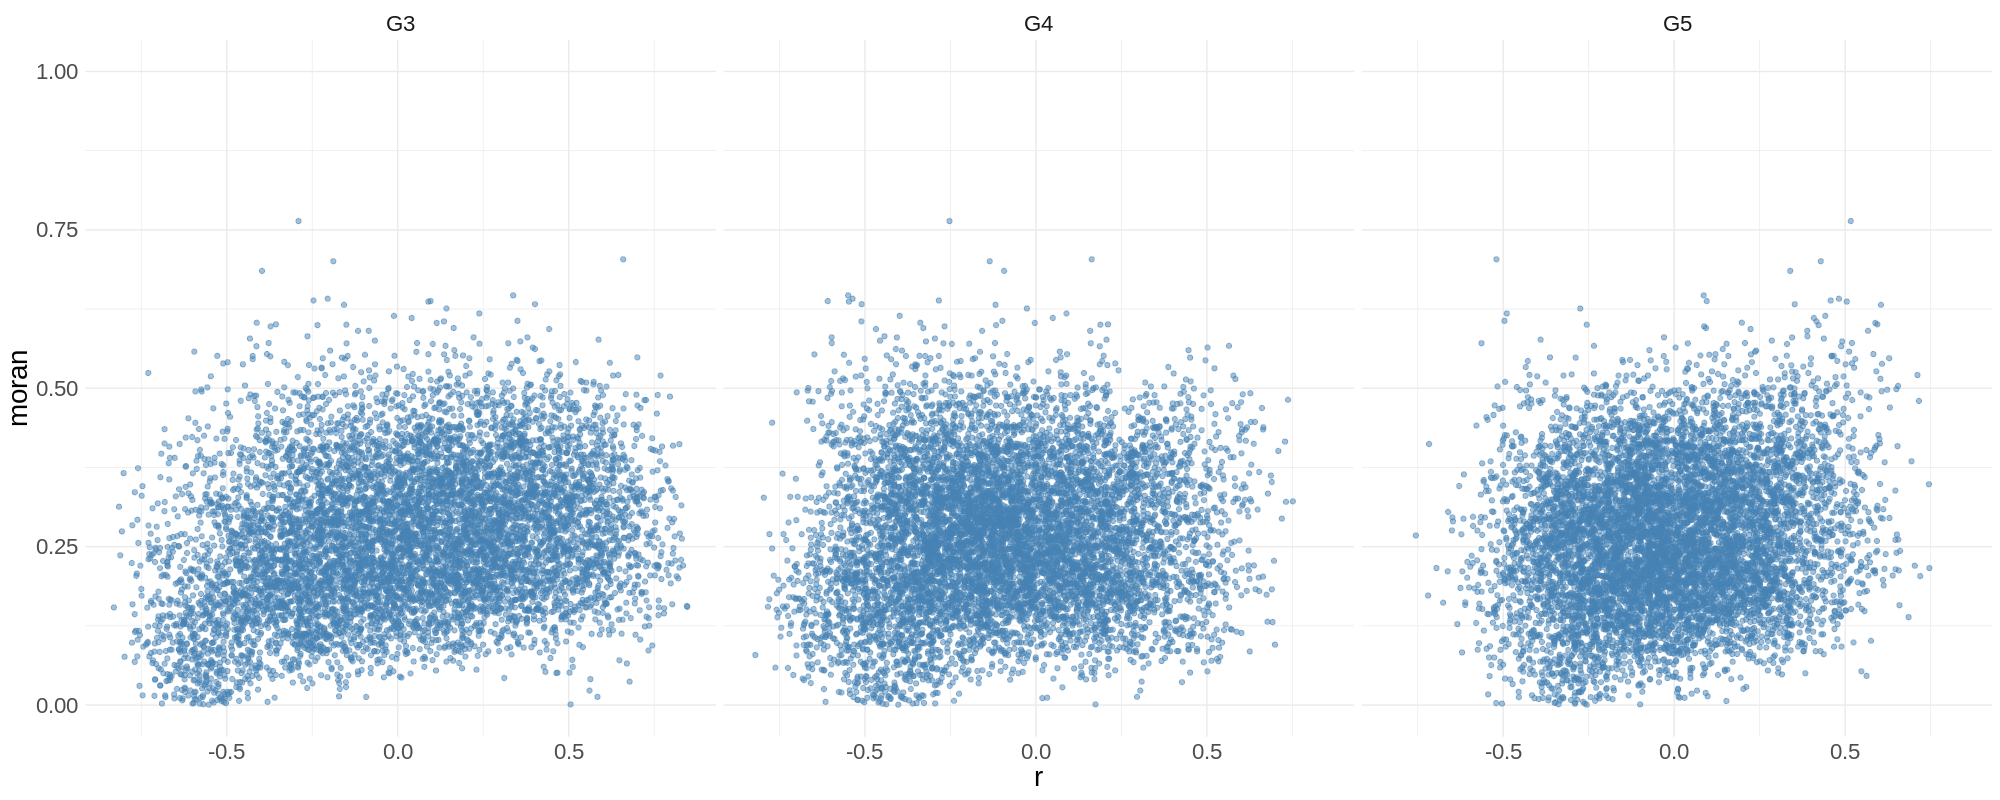

In [462]:
%%R -i df_plot -w 20 -h 8 --units in -r 100
df_plot %>% 
ggplot(aes(r, moran)) +
facet_wrap(~G) +
geom_point(color='steelblue', alpha=.5) + 
ylim(c(0,1)) +
theme_minimal() + 
theme(text=element_text(size=20))

## DK atlas VE

In [540]:
pca_dk_ds8 = gradientVersion('pca').fit('dk_ds8')

New gradients version: method=pca, kernel=None, sparsity=0, data=dk_ds8


In [544]:
pca_dk_ds8.eigenvalues / pca_dk_ds8.expression.var().sum()

array([0.671 , 0.1057, 0.0596, 0.0451, 0.0294])

## Other